# Sarcasm Dectection

## Description

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs Dataset News Headlines dataset for Sarcasm Detection

The dataset is collected from two news websites, theonion.com and huffingtonpost.com This new dataset has the following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements Content

Each record consists of three attributes: is_sarcastic: 1 if the record is sarcastic otherwise 0 headline: the headline of the news article article_link: link to the original news article. Useful in collecting supplementary data


In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## 1. Read and Explore the data

In [2]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Sarcastic count: 13634 i.e. 48.0%
Non Sarcastic count: 14985 i.e. 52.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


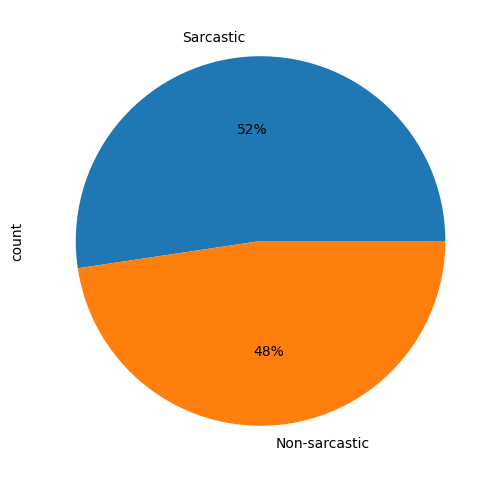

In [3]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Non Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))


In [4]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))


Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [5]:
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: budweiser unveils social anxiety bottle with 900% more label to pick at
label: 1

Headline: underwear worn out of respect for the dead
label: 1

Headline: world leader wondering why he just met with the former governor of massachusetts
label: 1

Headline: dennis miller deeply concerned about long-distance service
label: 1

Headline: tv commercial for beverage features woefully reckless pouring technique
label: 1



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: woman who's been on the pill for years thinking about switching to new set of debilitating side effects
label: 1

Headline: director of census bureau calls for updated population report after realizing he forgot to count himself
label: 1

Headline: sony scores big win for playstation 5 after poaching yoshi from nintendo with 10-year $400 million contract
label: 1

Headline: 3-week-old jack-o'-lantern excited to give one last scare when slightest touch causes it to collapse into disgusting mush
label: 1

Headline: border patrol authorities, militia in tense standoff over claim to detain migrant family they caught at same time
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
--------------

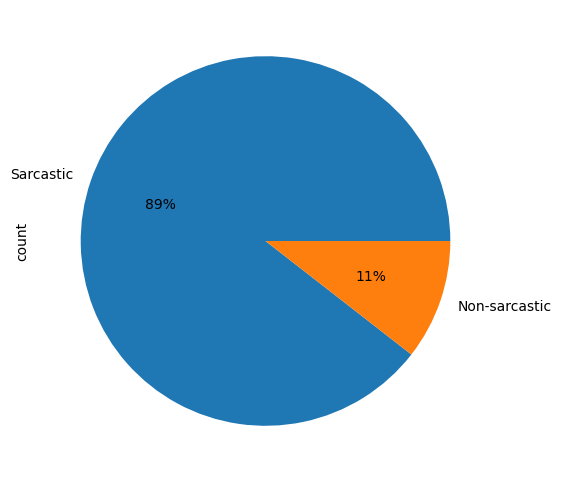

In [6]:
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))


## 2.Retain relevant columns

In [7]:
print('Dropping `article_link` column from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` column from the data
------------------------------------------------------------


## 3. Get length of each sentence

In [14]:
lengths = data['headline'].str.len()

In [15]:
print('Headline:', data['headline'][1])
print('Length:',lengths[1])

Headline: dem rep. totally nails why congress is falling short on gender, racial equality
Length: 79


In [16]:
lengths.min()

7

In [17]:
lengths.max()

926

## 4.Define parameters

In [18]:
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spars\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spars\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

In [20]:
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
# Reference: https://www.programiz.com/python-programming/methods/string/translate
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])
# Second helper function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))
# Helper function for wordcloud
# Reference: https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [21]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))
print('--'*30)


------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
------------------------------------------------------------


In [22]:
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()
print('--'*40); print('Get the length of each line, find the lines ranges'); 
print('Length of line ranges from', data['line_length'].min(), 'to', data['line_length'].max()); print('--'*40)

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length:\n{}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the lines ranges
Length of line ranges from 7 to 893
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 893
Line with maximum length:
hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever

In [23]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: \n{}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Minimum number of words: 2
Maximum number of words: 151
Line with maximum number of words: 
hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever that cause wooden mallet to slam down on serving spoo

Word Cloud of Sarcastic and Non-sarcastic Headlines


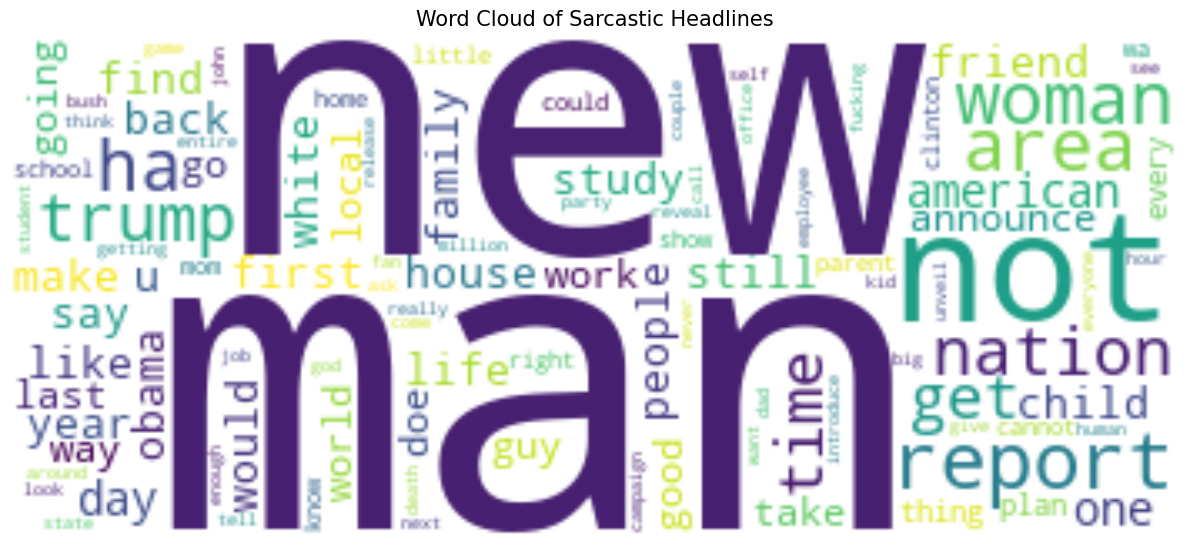

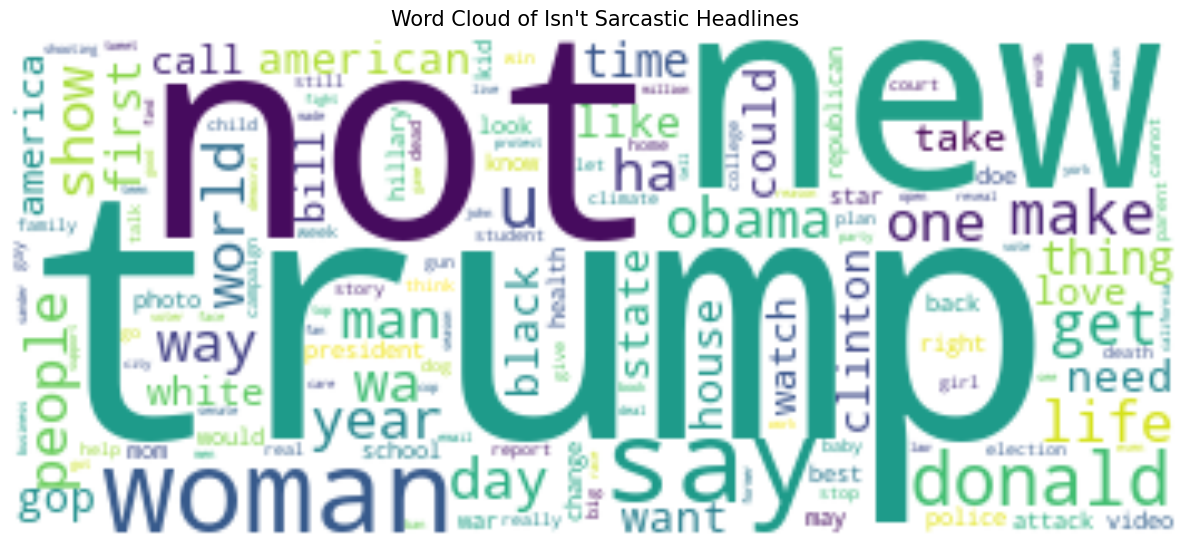

In [24]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')

In [25]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200 #200

In [26]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [27]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')


Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  326 2958 5781 2067    2  692 1093]

Label of the first headline: 1


In [28]:
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 26042


In [29]:
file_path = r"C:\Users\spars\Desktop\glove.6B.50d.txt\glove.6B.50d.txt"
f = open(file_path, encoding="utf8")
embeddings = {}
for o in f:
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [30]:
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) != embedding_size:
            # Repeat the embedding_vector to match the desired size
            embedding_vector = np.tile(embedding_vector, embedding_size // len(embedding_vector) + 1)[:embedding_size]
        embedding_matrix[i] = embedding_vector
        
len(embeddings.values())

400000

# Define and compile a Bidirectional LSTM model

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 151
Number of unique words in training dataset: 9975
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 151
Number of unique words in test dataset: 7640


In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dropout, Dense

# Define your model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, embeddings_initializer=Constant(embedding_matrix), input_shape=(maxlen,), trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 151, 200)       │     5,208,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 151, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,586,513 (21.31 MB)

 Trainable params: 378,113 (1.44 MB)

 Non-trainable params: 5,208,400 (19.87 MB)

None


In [33]:
batch_size = 100
epochs = 10
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    ModelCheckpoint("model_checkpoint.keras", save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-6)
]

# Train the model with defined callbacks
h = model.fit(x_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=2, callbacks=callbacks)

Epoch 1/10
184/184 - 112s - 607ms/step - accuracy: 0.6319 - loss: 0.6344 - val_accuracy: 0.7646 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 2/10
184/184 - 108s - 589ms/step - accuracy: 0.7729 - loss: 0.4906 - val_accuracy: 0.8017 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 3/10
184/184 - 111s - 602ms/step - accuracy: 0.8022 - loss: 0.4408 - val_accuracy: 0.8176 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 4/10
184/184 - 111s - 601ms/step - accuracy: 0.8234 - loss: 0.3970 - val_accuracy: 0.8329 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 5/10
184/184 - 115s - 625ms/step - accuracy: 0.8433 - loss: 0.3653 - val_accuracy: 0.8386 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 6/10
184/184 - 104s - 567ms/step - accuracy: 0.8564 - loss: 0.3404 - val_accuracy: 0.8345 - val_loss: 0.3799 - learning_rate: 0.0010
Epoch 7/10
184/184 - 121s - 659ms/step - accuracy: 0.8669 - loss: 0.3138 - val_accuracy: 0.8423 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 8/10
184/184 - 118s -

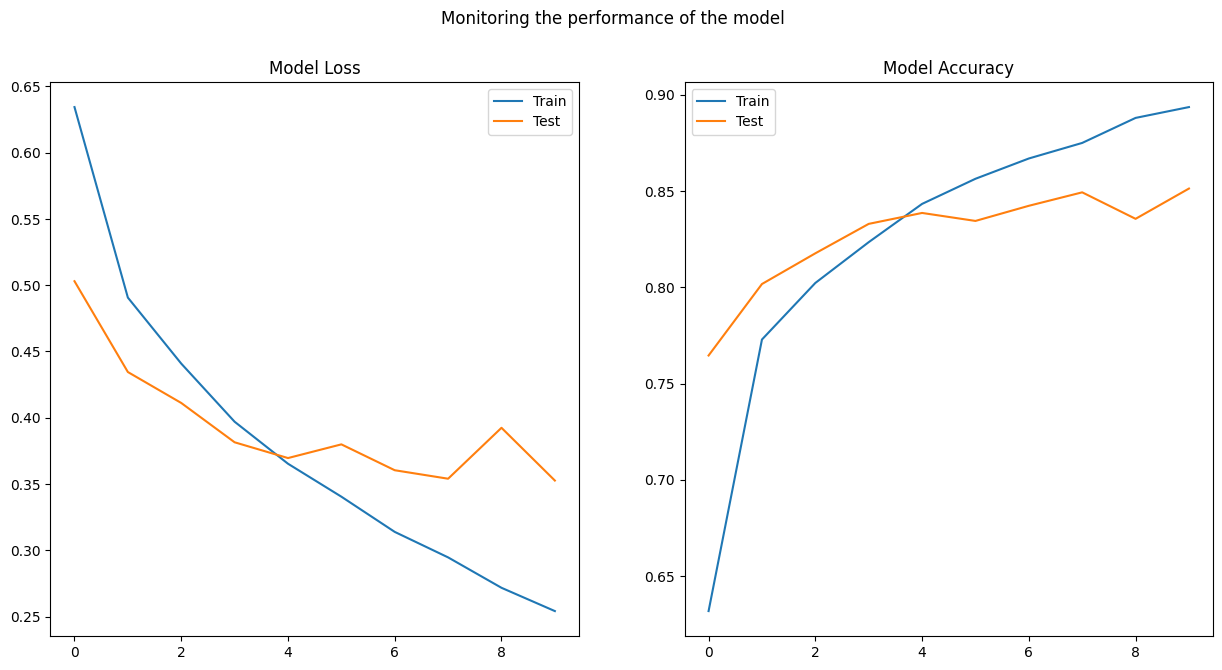

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 85.0


In [36]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2979
           1       0.85      0.84      0.85      2745

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2565,430
Sarcastic,414,2315


------------------------------------------------------------


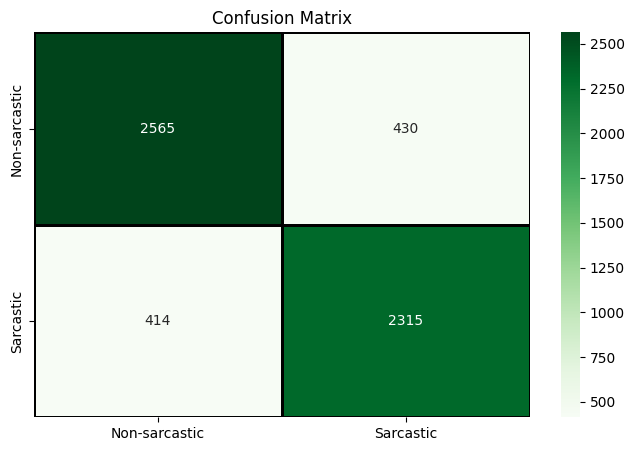

In [37]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Greens', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')


## Saving Model

In [55]:
# Preprocess user input
def preprocess_input(text):
    text = text.lower()
    text = replace_words(text)
    text = remove_punctuation(text)
    text = lem(text)
    # Other preprocessing steps if necessary
    return text

# Tokenize preprocessed text
def tokenize_text(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences

# Take user input
user_input = input("Enter a headline: ")

# Preprocess user input
preprocessed_input = preprocess_input(user_input)

# Tokenize preprocessed input
tokenized_input = tokenize_text(preprocessed_input)

# Make prediction
prediction = model.predict(tokenized_input)

# Convert prediction to label
if prediction > 0.5:
    print("Prediction: Sarcastic")
else:
    print("Prediction: Not Sarcastic")




Enter a headline: You did'nt failed again this time
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: Not Sarcastic
